# Transfer learning and fine-tuning (Task 2)
For the second task, we analyze the pretrained Xception model on chest x-ray images. We investigate how to classify images of normal and pneumonia samples by using the transfer learning from a pretrained network.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os

print(tf.__version__)

# Mount google drive to save the dataset and results
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data preprocessing

### Data Load

To have good processing speed with Google colab, we store the Chest x-ray dataset in Google drive 

In [2]:
# The path in Google drive that the Chest x-ray images are located
PATH = '/content/drive/MyDrive/Data/'

# The definition of train/val/test data path
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')
test_dir = os.path.join(PATH, 'test')

# The definition of bactch size and image size
BATCH_SIZE = 32
IMG_SIZE = (256, 256)

# Using image_dataset_from_directory to access training data
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 12880 files belonging to 2 classes.


In [3]:
# Using image_dataset_from_directory to access validation data
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

# Using image_dataset_from_directory to access test data
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 4165 files belonging to 2 classes.
Found 4250 files belonging to 2 classes.


Show the first nine images and labels from the training set:

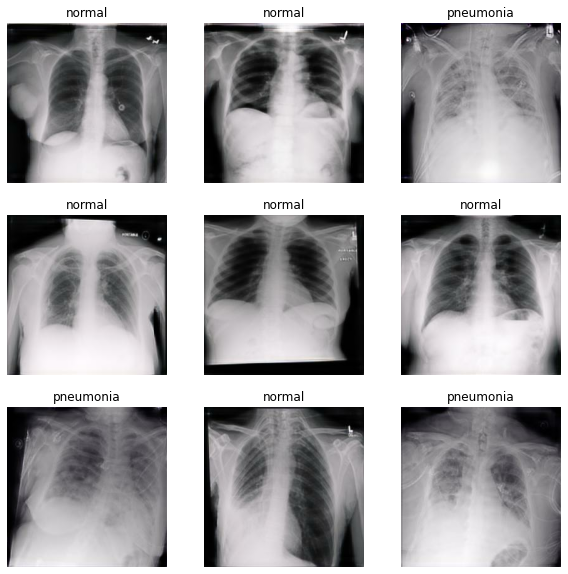

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Using the buffered prefetching to load images from disk without having I/O become blocking.

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Data Augmentation
Using data augmentation to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. 

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Applying the model layers to the same image and see the result.

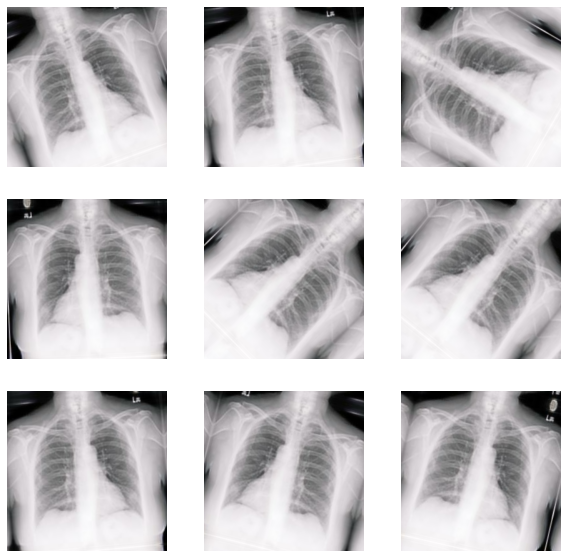

In [7]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

We use `tf.keras.applications.Xception` for use as our base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. 

In [8]:
preprocess_input = tf.keras.applications.xception.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

## Create the base model from the pre-trained Xception
Since the last layer of Xception is not useful for our model we disable it. Also, we include the model with imagenet weights

In [10]:
# Create the base model from the pre-trained model Xception
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.xception.Xception(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

83697664/83683744 [==============================] - 0s 0us/step


We use from base model to extract the features according to pretrained model

In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 2048)


By setting layer.trainable = False, we prevents the weights in a given layer from being updated during training. 

In [12]:
base_model.trainable = False

In [13]:
# The Xception summary
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [15]:
# To convert the features to  a single 2048-element vector per image.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

# To convert these features into a single prediction per image
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers 

In [16]:
inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Compiling the model before training it. 

In [17]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

The 20.8 million parameters in Xception are frozen, but there are 2.049 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [19]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, we see ~77% accuracy on the validation set.


In [20]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

131/131 [==============================] - 672s 5s/step - loss: 0.6466 - accuracy: 0.7762


In [21]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.65
initial accuracy: 0.78


We fit the model with training set 

In [22]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
403/403 [==============================] - 1475s 4s/step - loss: 0.4560 - accuracy: 0.7771 - val_loss: 0.4378 - val_accuracy: 0.7772
Epoch 2/10
403/403 [==============================] - 96s 237ms/step - loss: 0.3540 - accuracy: 0.7947 - val_loss: 0.3845 - val_accuracy: 0.7789
Epoch 3/10
403/403 [==============================] - 96s 237ms/step - loss: 0.3005 - accuracy: 0.8319 - val_loss: 0.3475 - val_accuracy: 0.7930
Epoch 4/10
403/403 [==============================] - 96s 238ms/step - loss: 0.2617 - accuracy: 0.8653 - val_loss: 0.3208 - val_accuracy: 0.8077
Epoch 5/10
403/403 [==============================] - 96s 238ms/step - loss: 0.2388 - accuracy: 0.8829 - val_loss: 0.3019 - val_accuracy: 0.8206
Epoch 6/10
403/403 [==============================] - 96s 237ms/step - loss: 0.2209 - accuracy: 0.8978 - val_loss: 0.2864 - val_accuracy: 0.8375
Epoch 7/10
403/403 [==============================] - 96s 237ms/step - loss: 0.2085 - accuracy: 0.9018 - val_loss: 0.2768 - val_acc

### Learning curves

The training and validation accuracy/loss when using the Xception base model as a fixed feature extractor.

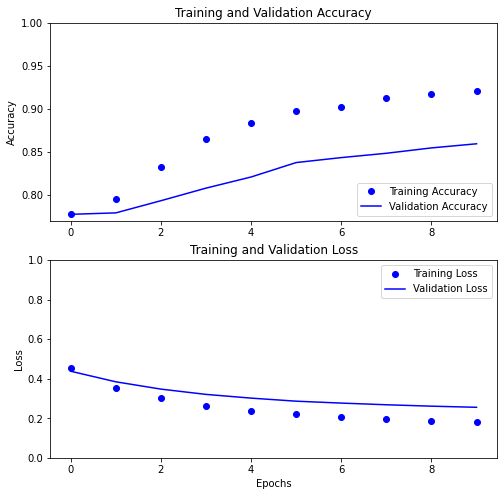

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, 'bo', label='Training Accuracy')
plt.plot(val_acc, 'b', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, 'bo', label='Training Loss')
plt.plot(val_loss, 'b', label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.show()

## Fine tuning
To increase the performance, we are to "fine-tune" the weights of the top layers of the pre-trained model alongside the training of the classifier you added. Then, we need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. 

In [24]:
base_model.trainable = True

In [25]:
# The number of layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  132


### Recompile the model

with lower learning rate to prevent from overfitting

In [26]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [28]:
len(model.trainable_variables)

41

Fitting the model from rest of steps

In [29]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
403/403 [==============================] - 140s 334ms/step - loss: 0.0952 - accuracy: 0.9621 - val_loss: 0.0937 - val_accuracy: 0.9544
Epoch 11/20
403/403 [==============================] - 134s 331ms/step - loss: 0.0594 - accuracy: 0.9770 - val_loss: 0.0559 - val_accuracy: 0.9755
Epoch 12/20
403/403 [==============================] - 134s 332ms/step - loss: 0.0383 - accuracy: 0.9853 - val_loss: 0.0483 - val_accuracy: 0.9782
Epoch 13/20
403/403 [==============================] - 134s 331ms/step - loss: 0.0350 - accuracy: 0.9884 - val_loss: 0.0495 - val_accuracy: 0.9750
Epoch 14/20
403/403 [==============================] - 134s 331ms/step - loss: 0.0275 - accuracy: 0.9901 - val_loss: 0.0317 - val_accuracy: 0.9856
Epoch 15/20
403/403 [==============================] - 134s 331ms/step - loss: 0.0230 - accuracy: 0.9916 - val_loss: 0.0448 - val_accuracy: 0.9806
Epoch 16/20
403/403 [==============================] - 134s 331ms/step - loss: 0.0227 - accuracy: 0.9914 - val_loss: 0

### Learning curves

The training and validation accuracy/loss when using the Xception base model as a fixed feature extractor.

In [30]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, 'bo', label='Training Accuracy')
plt.plot(val_acc, 'b', label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, 'bo', label='Training Loss')
plt.plot(val_loss, 'b', label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

The performance of model on new data using test set.

In [32]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

133/133 [==============================] - 672s 5s/step - loss: 0.0390 - accuracy: 0.9821
Test accuracy : 0.9821176528930664
